In [1]:
%reload_ext autoreload
%autoreload 2

In [20]:
import gc

from argparse import Namespace
from mimetypes import suffix_map
from pathlib import Path
import numpy as np
import yaml
import torch

from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from kolmopy.dataloaders import TurboFlowDataModule
import kolmopy.utils.viz_utils as viz
import kolmopy.utils.phy_utils as phy

import matplotlib.pyplot as plt

In [3]:
base_dir = Path('/','home','dicarlo_d','Documents','Code','TurboSuperResultion','recipes','turb_mfn_spec')
data_dir = Path('/','home','dicarlo_d','Documents','Code','TurboSuperResultion','.cache', 'Synth2D_0003.hdf5')
fig_path = base_dir / Path('figures')
res_path = base_dir / Path('results')

In [4]:
seed = 666
seed_everything(seed, workers=True)

# train
batch_size = {
    'train' : 64*64
,   'val'   : 64*64
,   'test'  : 64*64
}
dx = {
    'train' : 4
,   'val'   : 4
,   'test'  : 1
}
dt = {
    'train' : 1
,   'val'   : 1
,   'test'  : 1
}
time_idxs = np.array([21]) #np.array([0, 10, 20, 30])

run = 'moMFN'

model_params = {
    'name' : run
,   'cnn' : False
,   'do_divfree' : False
}

str_time = len(time_idxs) if not time_idxs is None else 'all'
exp_suffix = f'{str_time}x32x32'

hparams = {
    'name': model_params['name'],
    'do_time' : True,
    'do_cnn' : model_params['cnn'],
    'mlp_layers_num': 4,
    'mlp_layers_dim': 128, 
    'mlp_last_actfn': 'tanh',
    'rff_num_space': 128,
    'rff_scale_space': 10,
    'rff_num_time': 64, 
    'rff_scale_time': 1,
    'do_divfree': model_params['do_divfree'],
    'lam_sdiv': 0, 
    'lam_sfn':  0,    
    'lam_spec': 0,
    'lam_grads':0,    
    'lam_curl' :0,
    'lam_pde' : 0,
    'lam_weight': 0.5e-4,  # L2 reg on the NN's weights
    'sfn_min_x': 1./256., # maximal resolution
    'sfn_num_centers': 32,
    'sfn_num_increments':8,
    'sfn_patch_dim': 16 # (P/2)
}

Global seed set to 666


(128, 128, 2)
(128, 128, 2)
Low passing with scale: 16
Low passing with scale: 32
Low passing with scale: 64
Low passing with scale: 128


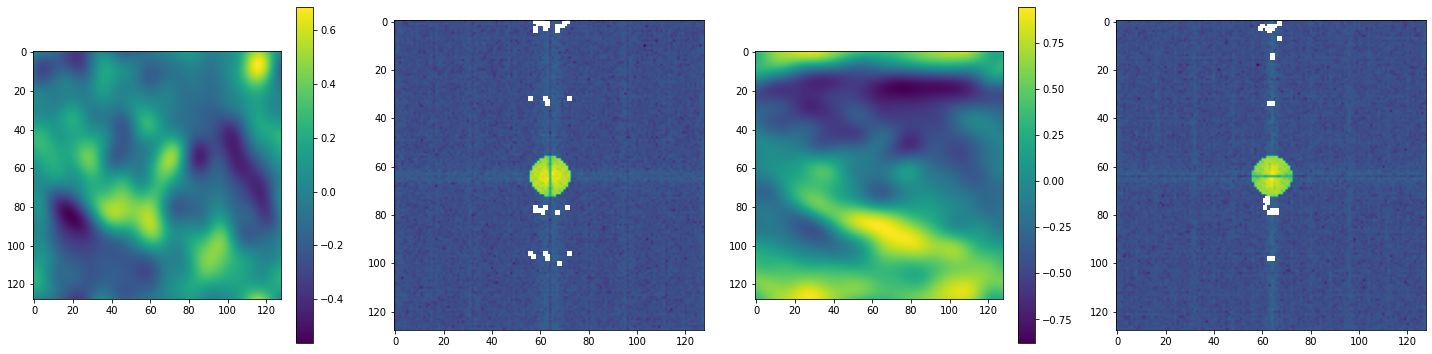

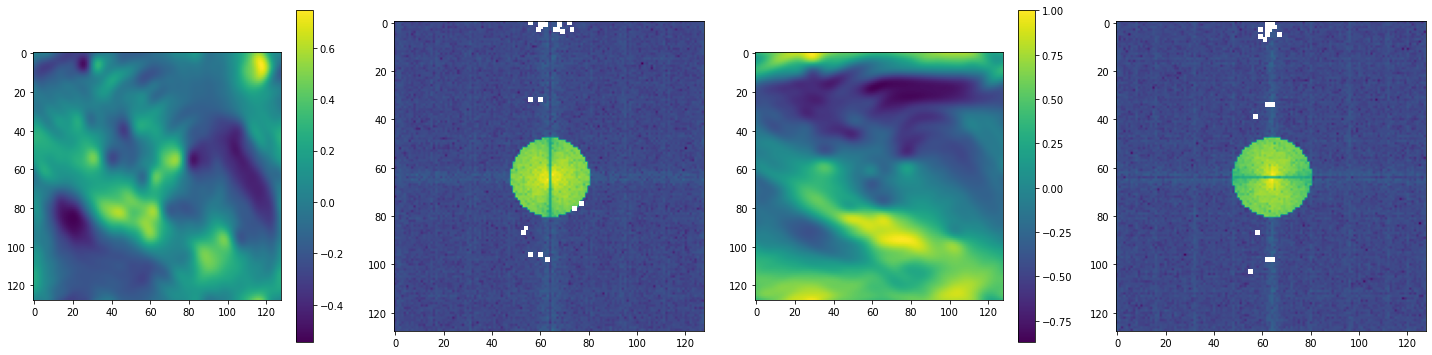

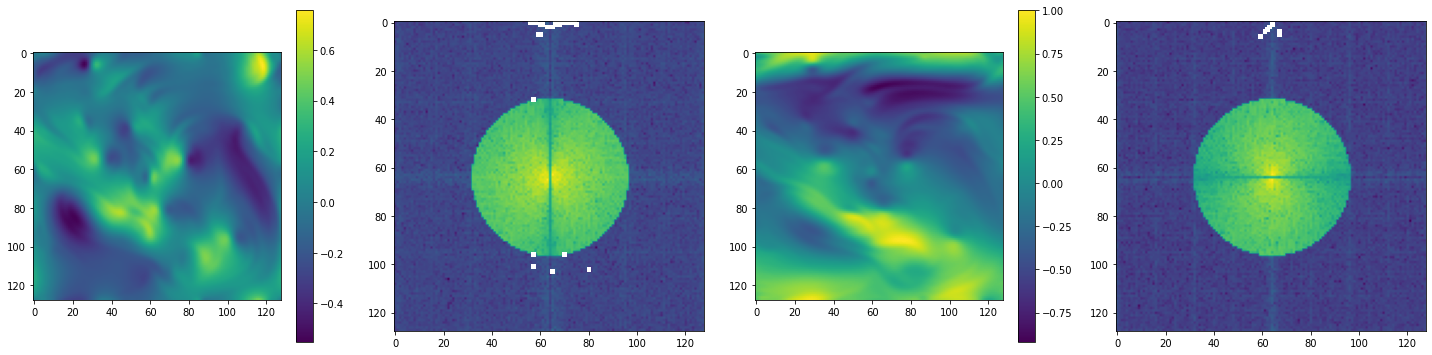

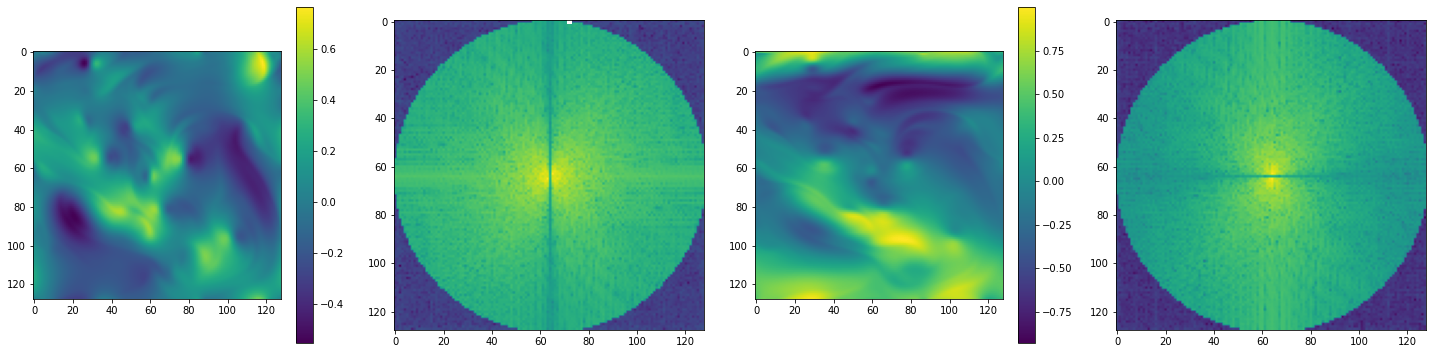

(128, 128, 2)
(128, 128, 2)
Low passing with scale: 16
Low passing with scale: 32
Low passing with scale: 64
Low passing with scale: 128


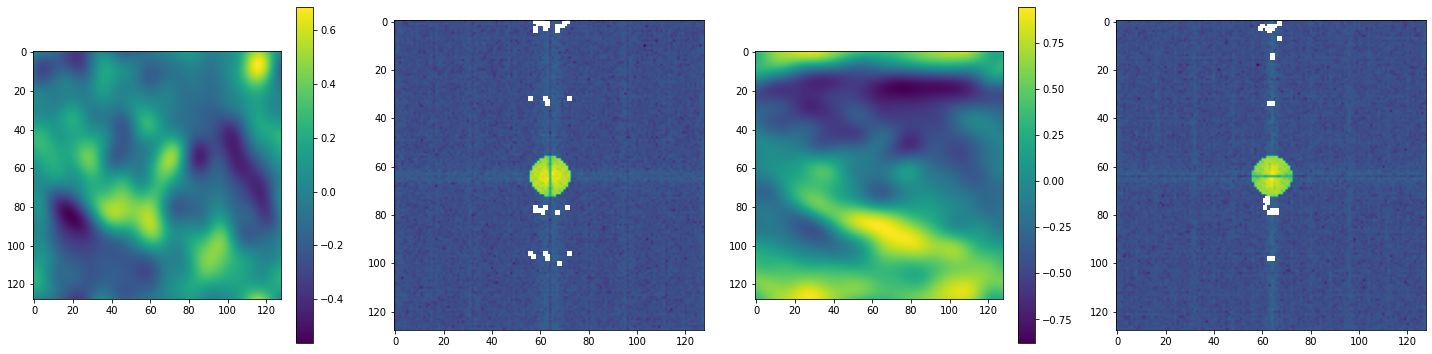

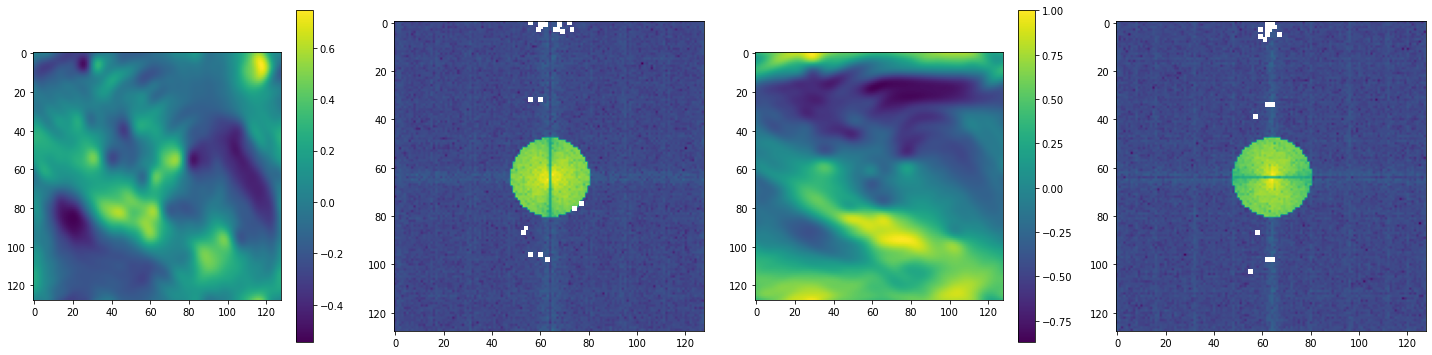

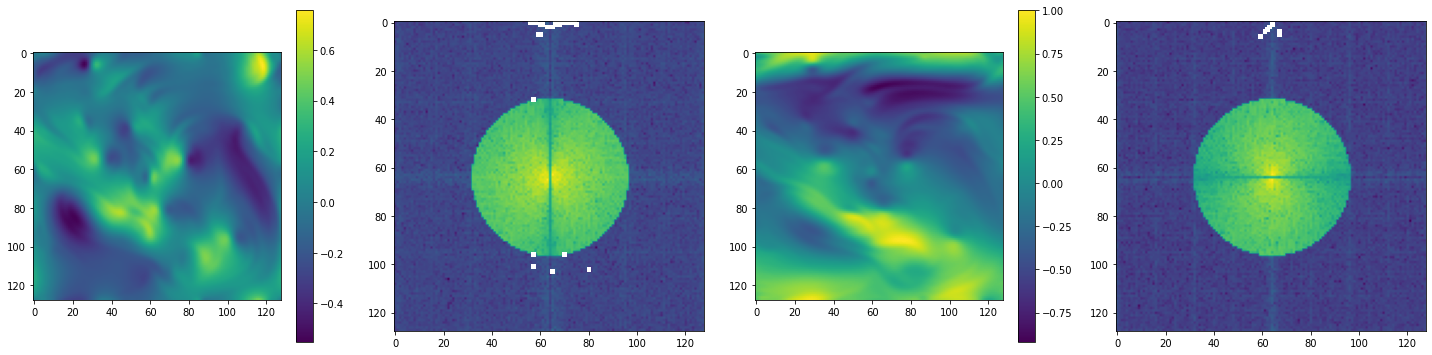

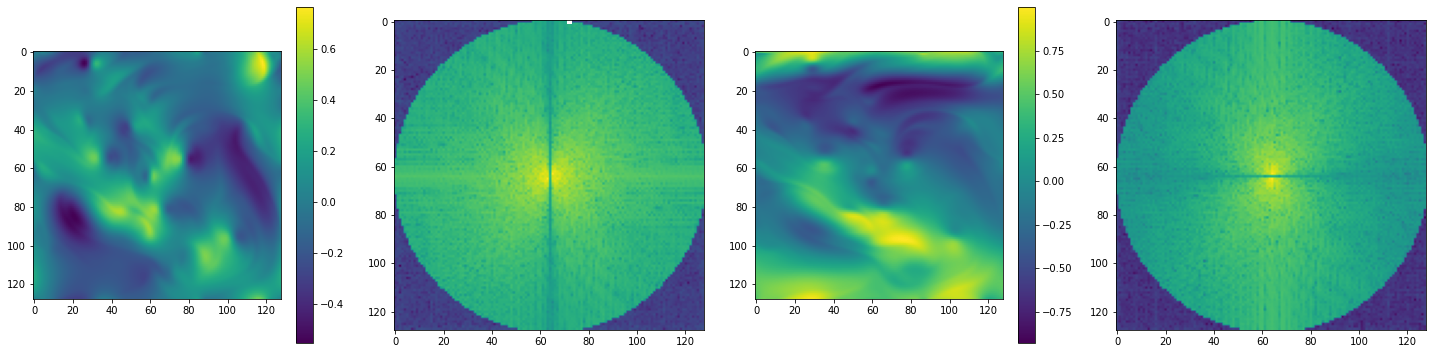

torch.Size([16384, 2]) torch.Size([16384, 2]) (128, 2) (128, 128, 2) (128, 128, 2)


In [46]:
# load dataset for TRAIN
dm_train = TurboFlowDataModule(
    dataset='Synth2D', 
    data_dir=data_dir,
    time_idx=time_idxs,

    train_batch_size=batch_size['train'],
    val_batch_size=batch_size['val'],
    test_batch_size=batch_size['test'],

    train_downsampling_space=dx['train'],
    val_downsampling_space=dx['val'],
    test_downsampling_space=dx['test'],

    train_downsampling_time=dt['train'],
    val_downsampling_time=dt['val'],
    test_downsampling_time=dt['val'],

    train_shuffle=True,
    val_shuffle=False,
    test_shuffle=False,
    num_workers=8)

dm_train.setup(stage='fit')

# datasets = [dm_train.train_dataset, dm_train.val_dataset]
datasets = [dm_train.train_dataset]
for dataset in datasets:
    X, y, extra = dataset[:]
    print(X.shape, y.shape, dataset.img_shape, dataset.vars_shape_img, dataset.fields_shape_img)

In [8]:
early_stop_callback = EarlyStopping(
    monitor='val/loss/tot', 
    patience=100,
    min_delta=1e-5)
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss/res_s1",
    dirpath=".torch_checkpoints",
    filename="Turb2D-%s-%s-{epoch:02d}-{val_loss:.2f}" % (hparams['name'], exp_suffix),
    save_top_k=1,
    mode="min",
)

trainer = Trainer(
    gpus=1,
    max_epochs=2500, 
    log_every_n_steps=5,
    check_val_every_n_epoch=10, 
    callbacks=[early_stop_callback, checkpoint_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [9]:
from turboflow.models.phyrff import plDivFreeRFFNet

model = plDivFreeRFFNet(**vars(Namespace(**hparams)))
print(model)
# # dset = dm_train.train_dataset[:]

# X, y = dm_train.train_dataset[:]
# model.target_lr_vars = X
# model.target_lr_fields = y
# # model.interp = interpolate.LinearNDInterpolator(X[:,1:], y)
# # print(model)

2022-06-24 11:17:52.874795: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Res Fourier Filter: Bmin 0 Bwidth 8
- min 0.5633437
- max 5.620833
Res Fourier Filter: Bmin 8 Bwidth 8
- min 8.1784
- max 11.273336
Res Fourier Filter: Bmin 16 Bwidth 16
- min 16.258516
- max 22.623308
Res Fourier Filter: Bmin 32 Bwidth 32
- min 32.394222
- max 45.081585
Res Fourier Filter: Bmin 64 Bwidth 64
- min 64.97318
- max 90.17243
plDivFreeRFFNet(
  (mfn): ResMFN(
    (g0): ResFourierFilter(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (g1): ResFourierFilter(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (g2): ResFourierFilter(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (g3): ResFourierFilter(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (g4): ResFourierFilter(
      (linear): Linear(in_features=2, out_features=128, bias=True)
    )
    (l1): Linear(in_features=128, out_features=128, bias=True)
    (l2): Linear(in_features=128, out_features=128, bias=T

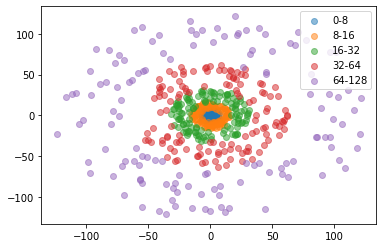

In [10]:
g0 = model.mfn.g0
g1 = model.mfn.g1
g2 = model.mfn.g2
g3 = model.mfn.g3
g4 = model.mfn.g4

for g in [g0, g1, g2, g3, g4]:
    Bm = g.Bmin
    BM = Bm + g.Bwidth
    w = g.linear.weight.data.detach().cpu().numpy()
    plt.scatter(w[:,0], w[:,1], alpha=0.5, label=f'{Bm}-{BM}')

plt.legend()
plt.show()

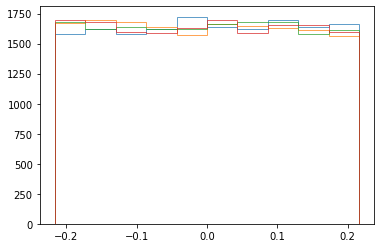

In [11]:
g1 = model.mfn.l1
g2 = model.mfn.l2
g3 = model.mfn.l3
g4 = model.mfn.l4

for g in [g1, g2, g3, g4]:
    w = g.weight.data.detach().cpu().numpy()
    plt.hist(w.flatten(), alpha=0.7, histtype='step')

plt.show()

In [12]:
trainer.fit(model, dm_train)
best_model_path = checkpoint_callback.best_model_path
best_model_score = checkpoint_callback.best_model_score

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | mfn  | ResMFN | 69.0 K
--------------------------------
69.0 K    Trainable params
0         Non-trainable params
69.0 K    Total params
0.276     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 666


here 0


/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (4) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

here 0


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

here 200


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

here 400


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

here 800


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

here 1200


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [13]:
print(best_model_path)
print(best_model_score)

/home/dicarlo_d/Documents/Code/TurboSuperResultion/notebooks/.torch_checkpoints/Turb2D-moMFN-1x32x32-epoch=1729-val_loss=0.00.ckpt
tensor(3.8676e-05, device='cuda:0')


cpu
cpu


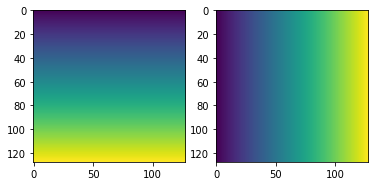

Scale 16


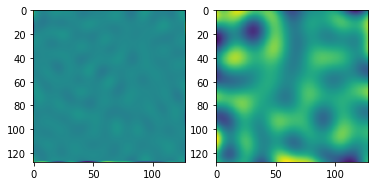

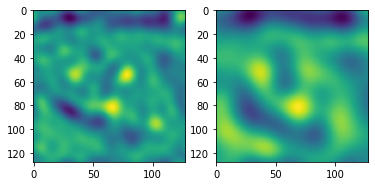

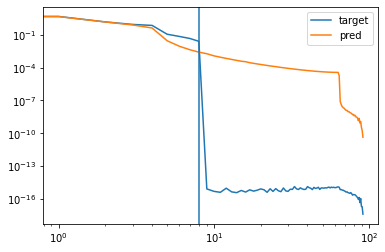

Scale 8


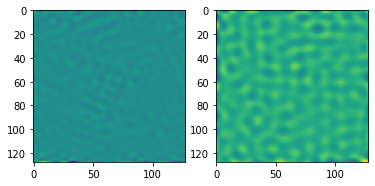

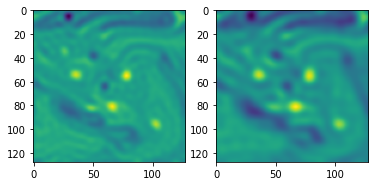

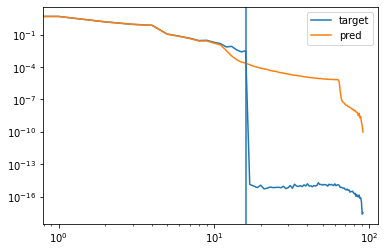

Scale 4


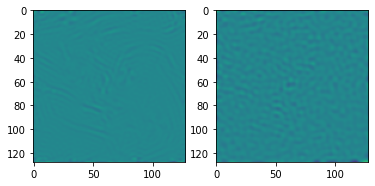

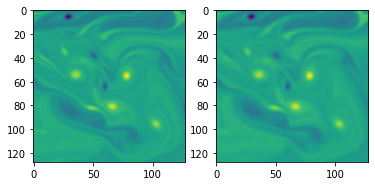

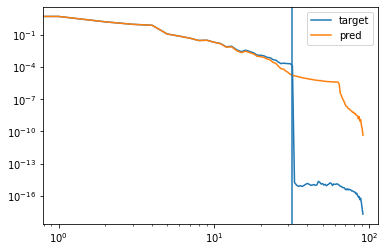

Scale 2


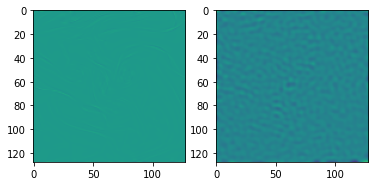

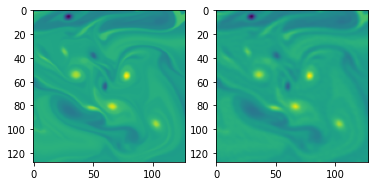

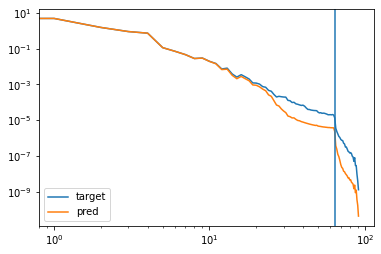

In [73]:
dataset = dm_train.train_dataset

xy, uv, uv_mid = dataset[:]

xy.to(model.device)
print(xy.device)
print(model.device)

uv_pred, uv_pred_mid = model(xy) 

vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img

x = xy.reshape(*vshape).detach().cpu().numpy()
plt.subplot(121)
plt.imshow(x[:,:,0])
plt.subplot(122)
plt.imshow(x[:,:,1])
plt.show()

# scales = ['1/16','1/8','1/4', '1/2']
scales = [16,8,4,2]

uv_mid = list(uv_mid) + [uv]
uv_pred_mid = list(uv_pred_mid) + [uv_pred]

for k in range(len(uv_mid)):
    u1 = uv_mid[k].reshape(*fshape).detach().cpu().numpy()
    u1_pred = uv_pred_mid[k].reshape(*fshape).detach().cpu().numpy()

    print(f'Scale {scales[k]}')
#     plt.figure(figsize=(15,10))
#     plt.title('Ref U')
#     plt.subplot(141)
#     plt.imshow(u1[:,:,0])
#     plt.subplot(142)
#     plt.title('Ref V')
#     plt.imshow(u1[:,:,1])
#     plt.subplot(143)
#     plt.title('Pred U')
#     plt.imshow(u1_pred[:,:,0])
#     plt.subplot(144)
#     plt.title('Pred V')
#     plt.imshow(u1_pred[:,:,1])
#     plt.tight_layout()
#     plt.show()
    
#     err = np.abs(u1 - u1_pred)**2
#     e = np.mean(err)
    
#     plt.figure(figsize=(20,5))
#     plt.suptitle(f'Error L2 = {e}')
#     plt.subplot(141, title=f'Error on U')
#     plt.imshow(err[:,:,0])
#     plt.colorbar()
#     plt.subplot(142, title='Error on V')
#     plt.imshow(err[:,:,1])
#     plt.colorbar()
#     ax = plt.subplot(143, title='Error Field')
#     viz.plot_2D_velocity_field(x, err, ax=ax)
#     ax = plt.subplot(144, title='Error Field Color')
#     viz.plot_middlebury_colors(err, ax=ax)
#     plt.tight_layout()
#     plt.show()
    
    
    div = phy.compute_divergence(x, u1)
    div_pred = phy.compute_divergence(x, u1_pred)
    
    plt.subplot(121)
    plt.imshow(div)
    plt.subplot(122)
    plt.imshow(div_pred)
    plt.show()
    
    w = phy.compute_vorticity(x, u1)
    w_pred = phy.compute_vorticity(x, u1_pred)
    
    plt.subplot(121)
    plt.imshow(w)
    plt.subplot(122)
    plt.imshow(w_pred)
    plt.show()
    
    spec, f = phy.powerspec(u1)
    spec_pred, f = phy.powerspec(u1_pred)
    plt.loglog(f, spec, label='target')
    plt.loglog(f, spec_pred, label='pred')
    plt.axvline(x=128 / scales[k])
    plt.legend()
    plt.show()

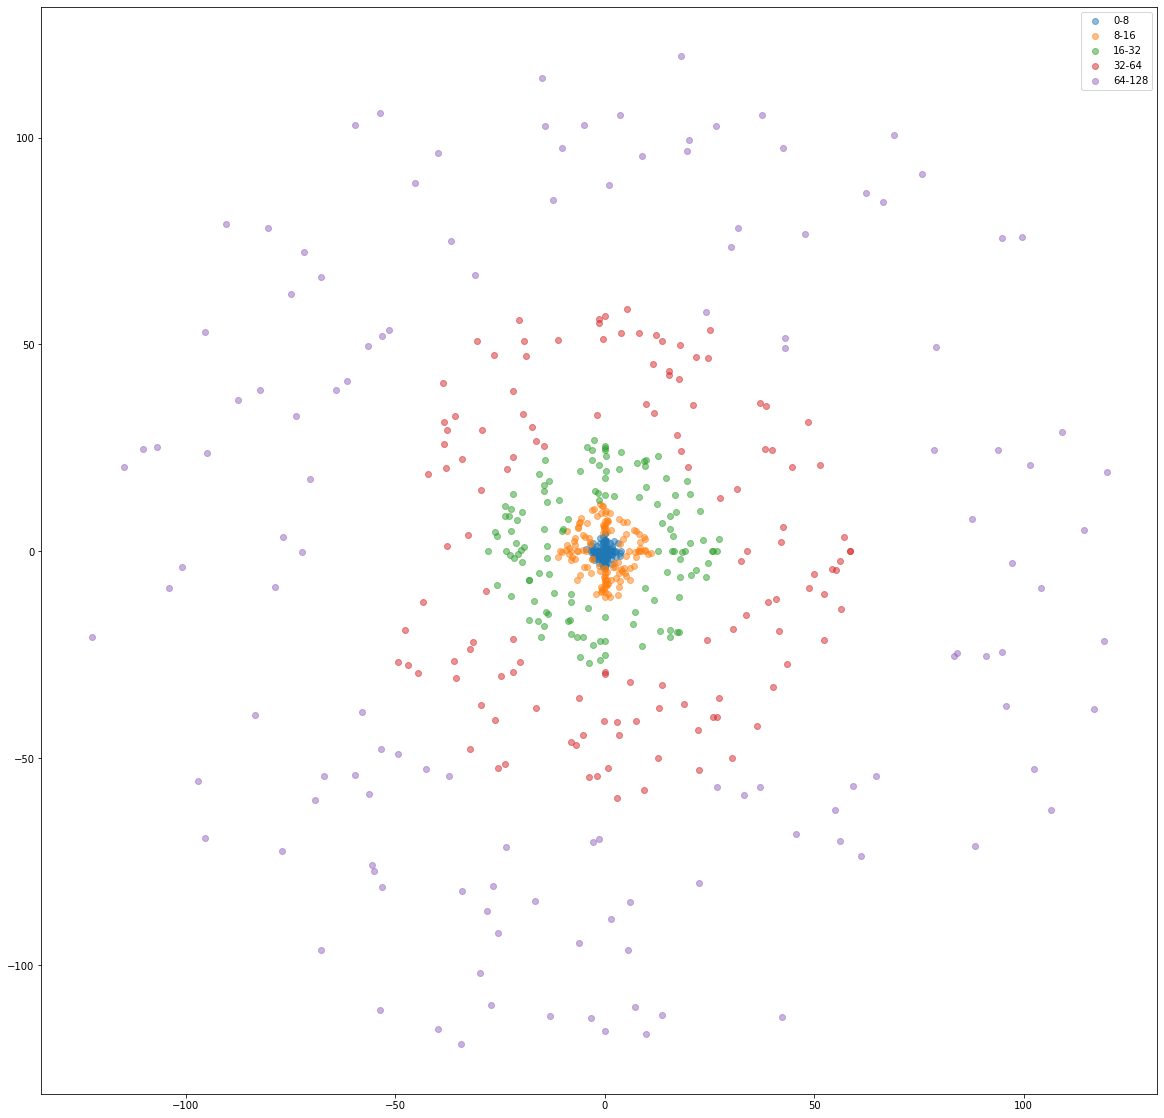

In [53]:
g0 = model.mfn.g0
g1 = model.mfn.g1
g2 = model.mfn.g2
g3 = model.mfn.g3
g4 = model.mfn.g4

plt.figure(figsize=(20,20))
for g in [g0, g1, g2, g3, g4]:
    Bm = g.Bmin
    BM = Bm + g.Bwidth
    w = g.linear.weight.data.detach().cpu().numpy()
    plt.scatter(w[:,0], w[:,1], alpha=0.5, label=f'{Bm}-{BM}')

plt.legend()
plt.show()

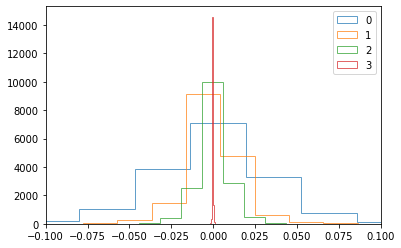

In [16]:
g1 = model.mfn.l1
g2 = model.mfn.l2
g3 = model.mfn.l3
g4 = model.mfn.l4

for k, g in enumerate([g1, g2, g3, g4]):
    w = g.weight.data.detach().cpu().numpy()
    plt.hist(w.flatten(), alpha=0.7, histtype='step', label=f'{k}')

plt.legend()
plt.xlim([-0.1, 0.1])
plt.show()

(512, 512, 2)
(512, 512, 2)
Low passing with scale: 64
Low passing with scale: 128
Low passing with scale: 256
Low passing with scale: 512


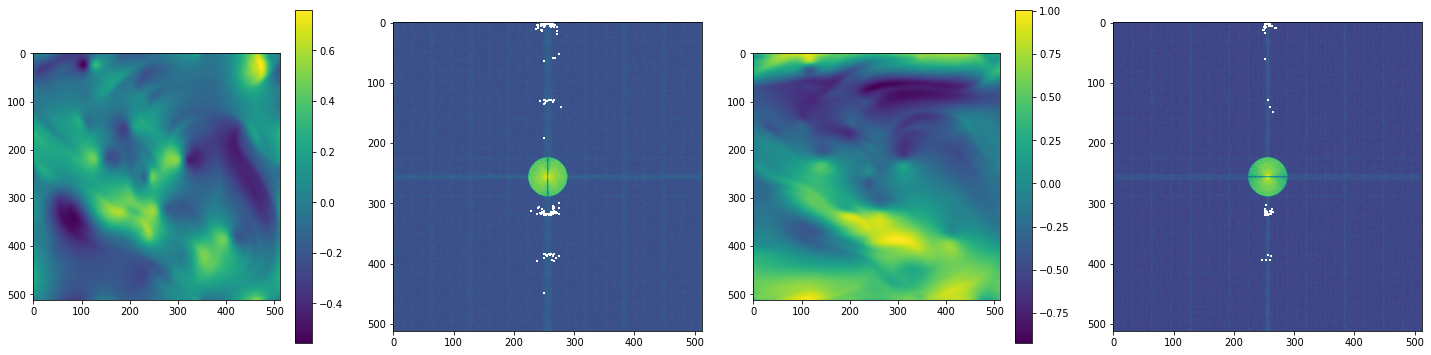

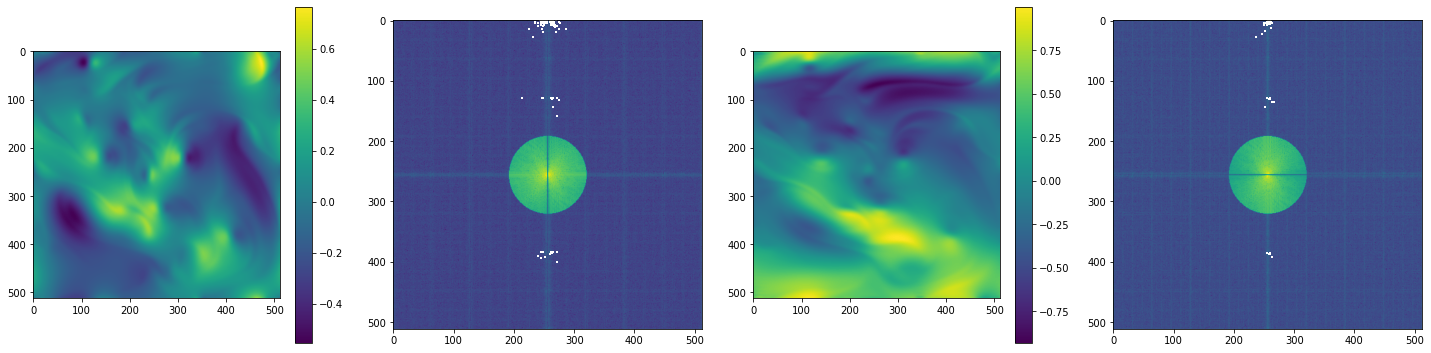

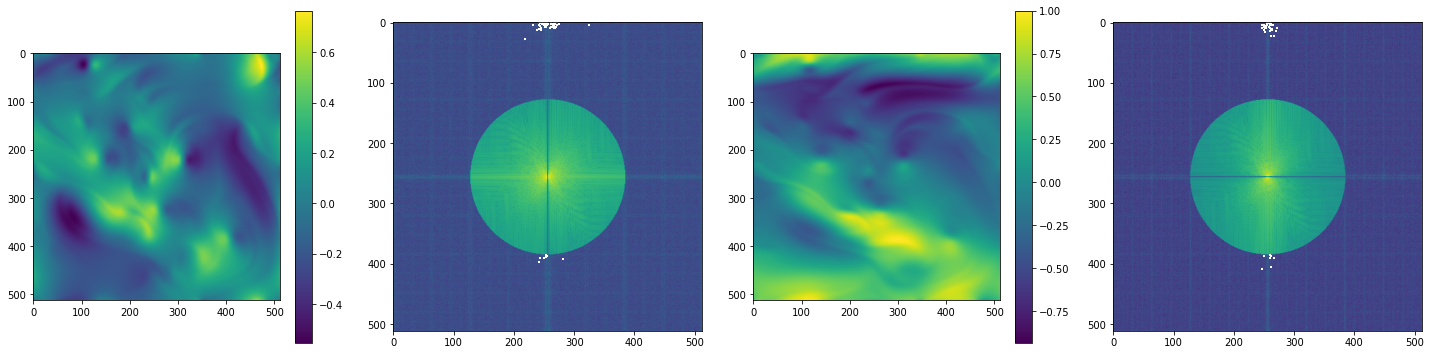

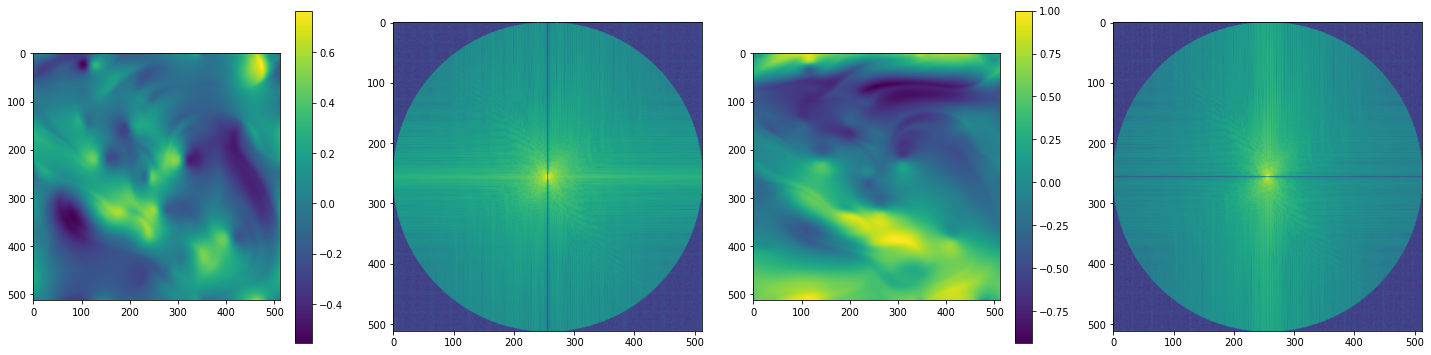

torch.Size([262144, 2]) torch.Size([262144, 2]) (512, 2) (512, 512, 2) (512, 512, 2)


In [47]:
dm_train.setup(stage='test')

datasets = [dm_train.test_dataset]
for dataset in datasets:
    X, y, extra = dataset[:]
    print(X.shape, y.shape, dataset.img_shape, dataset.vars_shape_img, dataset.fields_shape_img)

cpu
cpu


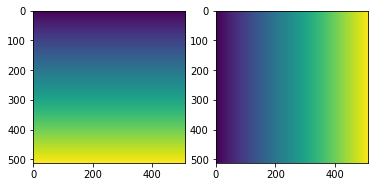

Scale 1/16


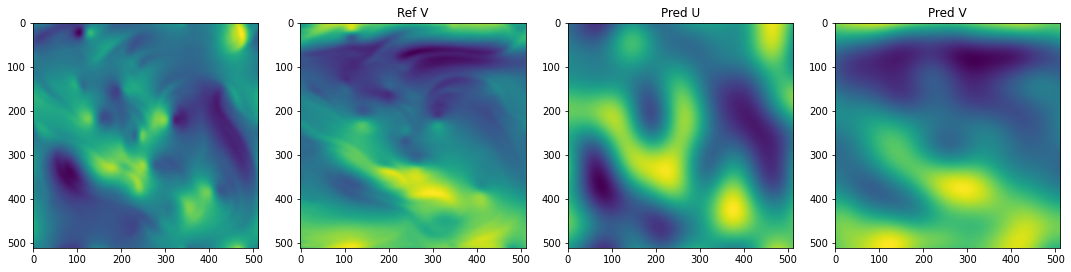

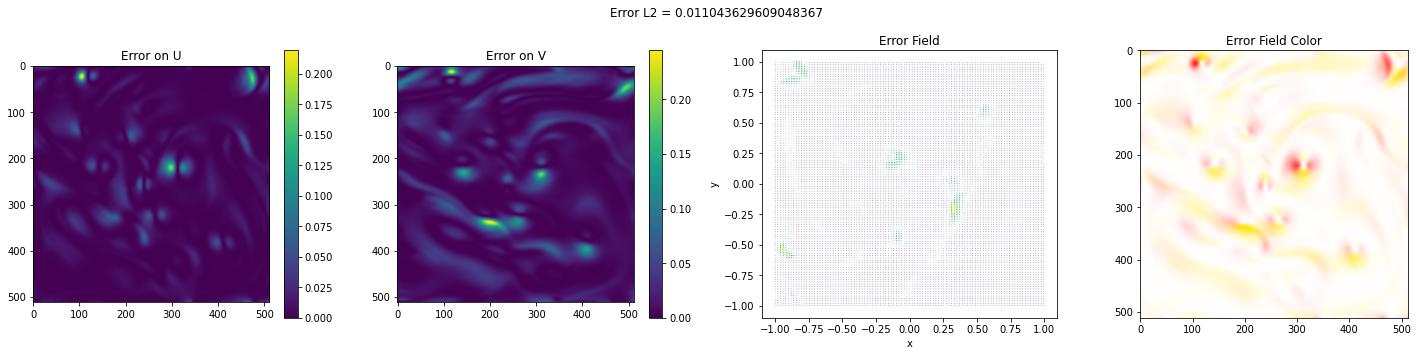

Scale 1/8


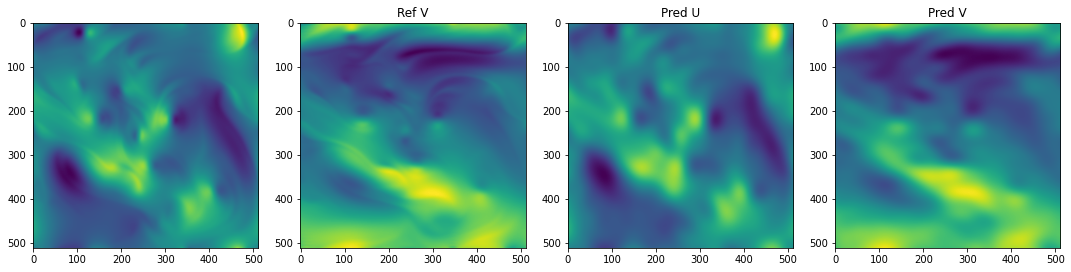

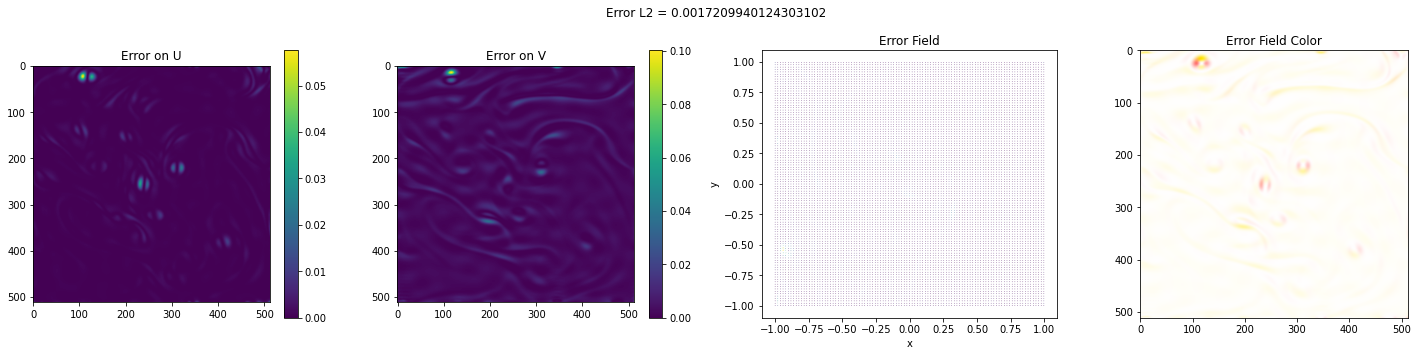

Scale 1/4


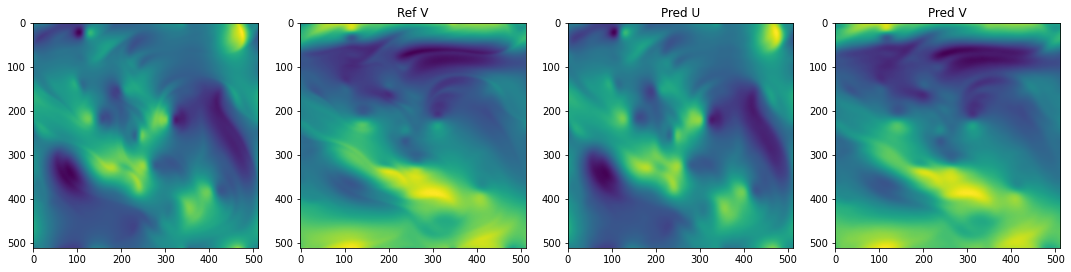

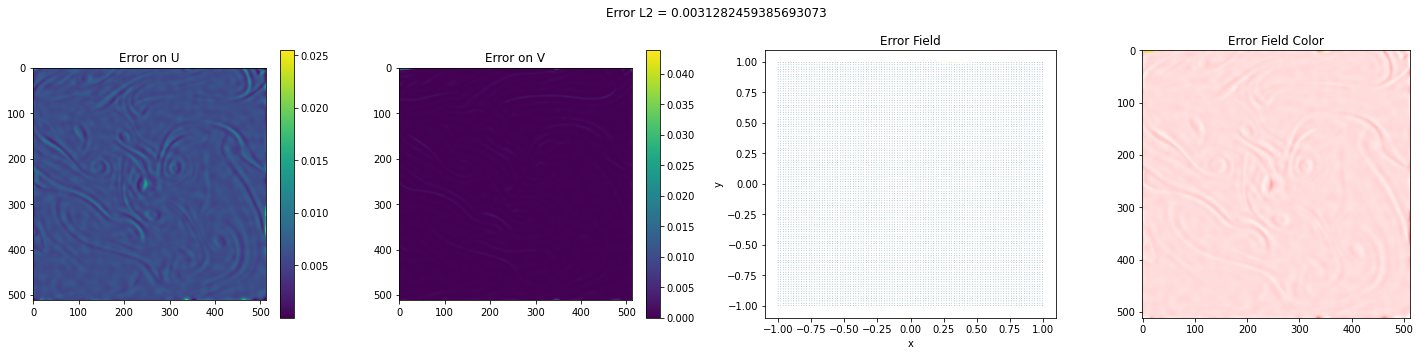

Scale 1/2: Traning


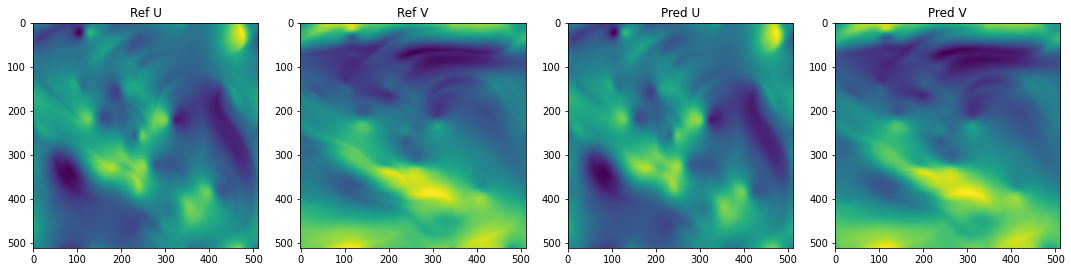

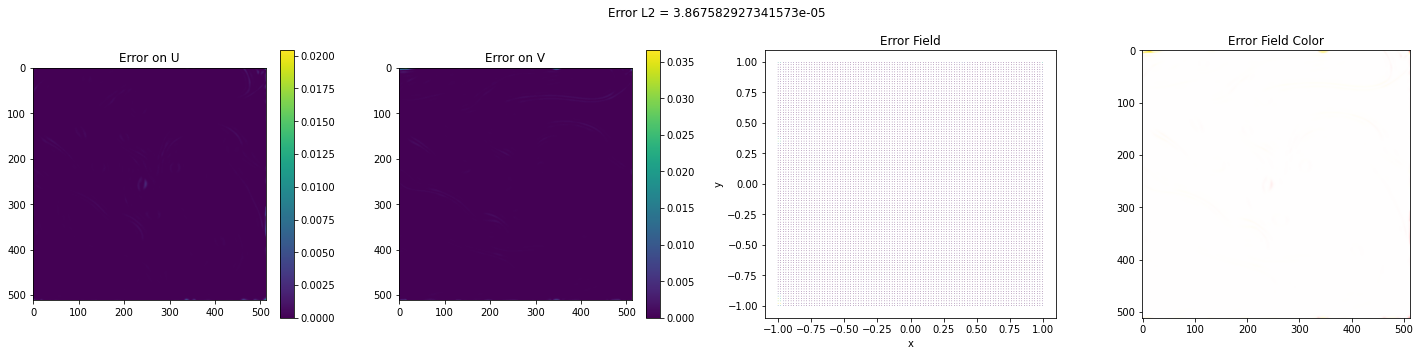

In [48]:
dataset = dm_train.test_dataset

xy, uv, uv_mid = dataset[:]

xy.to(model.device)
print(xy.device)
print(model.device)

uv_pred, uv_pred_mid = model(xy) 

vshape = dataset.vars_shape_img
fshape = dataset.fields_shape_img

x = xy.reshape(*vshape).detach().cpu().numpy()
plt.subplot(121)
plt.imshow(x[:,:,0])
plt.subplot(122)
plt.imshow(x[:,:,1])
plt.show()

scales = ['1/16','1/8','1/4']

for k in range(3):
    u1 = uv_mid[k].reshape(*fshape).detach().cpu().numpy()
    u1_pred = uv_pred_mid[k].reshape(*fshape).detach().cpu().numpy()

    print('Scale ' + scales[k])
    plt.figure(figsize=(15,10))
    plt.title('Ref U')
    plt.subplot(141)
    plt.imshow(u1[:,:,0])
    plt.subplot(142)
    plt.title('Ref V')
    plt.imshow(u1[:,:,1])
    plt.subplot(143)
    plt.title('Pred U')
    plt.imshow(u1_pred[:,:,0])
    plt.subplot(144)
    plt.title('Pred V')
    plt.imshow(u1_pred[:,:,1])
    plt.tight_layout()
    plt.show()
    
    err = np.abs(u1 - u1_pred)**2
    e = np.mean(err)
    
    plt.figure(figsize=(20,5))
    plt.suptitle(f'Error L2 = {e}')
    plt.subplot(141, title=f'Error on U')
    plt.imshow(err[:,:,0])
    plt.colorbar()
    plt.subplot(142, title='Error on V')
    plt.imshow(err[:,:,1])
    plt.colorbar()
    ax = plt.subplot(143, title='Error Field')
    viz.plot_2D_velocity_field(x, err, ax=ax)
    ax = plt.subplot(144, title='Error Field Color')
    viz.plot_middlebury_colors(err, ax=ax)
    plt.tight_layout()
    plt.show()
    
    
    
u = uv.reshape(*fshape).detach().cpu().numpy()
u_pred = uv_pred.reshape(*fshape).detach().cpu().numpy()

print('Scale 1/2: Traning')
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.title('Ref U')
plt.imshow(u[:,:,0])
plt.subplot(142)
plt.title('Ref V')
plt.imshow(u[:,:,1])
plt.subplot(143)
plt.title('Pred U')
plt.imshow(u_pred[:,:,0])
plt.subplot(144)
plt.title('Pred V')
plt.imshow(u_pred[:,:,1])
plt.tight_layout()
plt.show()

err = np.abs(u - u_pred)**2
e = np.mean(err_l2)

plt.figure(figsize=(20,5))
plt.suptitle(f'Error L2 = {e}')
plt.subplot(141, title=f'Error on U')
plt.imshow(err[:,:,0])
plt.colorbar()
plt.subplot(142, title='Error on V')
plt.imshow(err[:,:,1])
plt.colorbar()
ax = plt.subplot(143, title='Error Field')
viz.plot_2D_velocity_field(x, err, ax=ax)
ax = plt.subplot(144, title='Error Field Color')
viz.plot_middlebury_colors(err, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
dataset = dm_train.val_dataset
xy, uv, extra = dataset[:]
fshape = dataset.fields_shape_img
vshape = dataset.vars_shape_img

xy.requires_grad_(True)
uv_pred = model.mfn(xy)[0]

from turboflow.utils import torch_utils as tch

u, v = torch.split(uv_pred, 1, -1)
print(u.shape)

du = tch.diff(u, xy)
u_t, u_x, u_y = du.split(1, -1)

dv = tch.diff(v, xy)
v_t, v_x, v_y = dv.split(1, -1)

plt.imshow(u.detach().numpy().reshape(*fshape[:3])[0,:,:])
plt.show()
plt.imshow(u_x.detach().numpy().reshape(*fshape[:3])[0,:,:])
plt.show()

u_x_diff = np.diff(u.detach().numpy().reshape(*fshape[:3])[0,32,:])

plt.plot(u.detach().numpy().reshape(*fshape[:3])[0,32,:])
plt.plot(u_x.detach().numpy().reshape(*fshape[:3])[0,32,:])
plt.plot(u_x_diff)
plt.show()

In [ ]:
print(vshape)
print(fshape)
w = v_x - u_y

plt.imshow(w.detach().numpy().reshape(*fshape[:3])[1,:,:])

In [ ]:
dw = tch.diff(w, xy)
w_t, w_x, w_y = dw.split(1, -1)
ddw = tch.diff(dw, xy)
w_tt, w_xx, w_yy = ddw.split(1, -1)

# spatial change of vorticity / unit volume (u dot Nabla)w
w_spatial = u*w_x + v*w_y
# diffusion of vorticity / univ volume (nu Laplacian w)
diffusion = 0 # 1/self.Re
w_diffusion = diffusion*(w_xx + w_yy)

In [ ]:
plt.imshow(w_spatial.detach().numpy().reshape(*fshape[:3])[1,:,:])

In [ ]:
plt.imshow(w_t.detach().numpy().reshape(*fshape[:3])[1,:,:])

In [ ]:
plt.imshow(torch.abs(w_t + w_spatial).detach().numpy().reshape(*fshape[:3])[1,:,:])
plt.colorbar()

In [ ]:
from turboflow.utils import phy_utils as phy

In [ ]:
t = 0

UV = uv.detach().numpy().reshape(*fshape)
XY = xy.detach().numpy().reshape(*vshape)
print(UV.shape)
print(XY.shape)

plt.figure(figsize=(15,4))
plt.subplot(151)
plt.imshow(XY[t,:,:,0])
plt.subplot(152)
plt.imshow(XY[t,:,:,1])
plt.subplot(153)
plt.imshow(XY[t,:,:,2])
plt.subplot(154)
plt.imshow(UV[t,:,:,0])
plt.subplot(155)
plt.imshow(UV[t,:,:,1])
plt.tight_layout()
plt.show()

[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])

plt.figure(figsize=(12,5))
plt.subplot(141)
plt.imshow(Udx)
plt.subplot(142)
plt.imshow(Udy)
plt.subplot(143)
plt.imshow(Vdx)
plt.subplot(144)
plt.imshow(Vdy)
plt.tight_layout()
plt.show()

W = Vdx - Udy

plt.figure(figsize=(5,5))
plt.imshow(W)
plt.show()

In [ ]:
t=0
[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])
W0 = Vdx - Udy
t=1
[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])
W1 = Vdx - Udy
t=2
[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])
W2 = Vdx - Udy

Wdt = (W1-W0)/4 + (W2-W1)/4
plt.imshow(Wdt)
plt.colorbar()
plt.show()

In [ ]:
t=1
[[Udx, Udy], [Vdx, Vdy]] = phy.my_grad([UV[t,:,:,0], UV[t,:,:,1]], [XY[t,:,0,1], XY[t,0,:,2]])
W1 = Vdx - Udy

[[Wdx, Wdy]] = phy.my_grad([W1], [XY[t,:,0,1], XY[t,0,:,2]])
Wspat = UV[t,:,:,0]*Wdx + UV[t,:,:,1]*Wdy
plt.imshow(Wspat)
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(Wdt/np.linalg.norm(Wdt) + Wspat/np.linalg.norm(Wspat))
plt.colorbar()